# Implements encoder/decoder for weak lensing outputs

In [ ]:
# extract tarfiles if necessary and set specs for run

In [5]:
import os
use_COLAB = 1

if use_COLAB == 1:
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)

Mounted at /content/gdrive


In [6]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random


# Specify the directory containing the .tar files
directory_path = './columbialensing/'


max_cosmologies = -1 #for testing.  Set to -1 to use everything.

number_batches = 10
#validation_split = 0.4  # use this fraction of the data for validation
normalize_by_RMS = False #set to one if you want to renormalize by RMS


# Set the learning rate
learning_rate = 0.005

# image_size
image_size = 1024 #really makes sense to use the 1024s
sub_image_size = 64 #needs to divide image size
number_subimages_across =image_size//sub_image_size


number_fits_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"

#extracts only if indicated (could make this more elegant by checking to see if they exist)
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)


# Read into memory the data

In [7]:
def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]


#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float16)
for idy, dir_name in enumerate(all_directories):
    if max_cosmologies>0 and idy >= max_cosmologies:
        break

    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]

    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension

reading in Om0.268_si0.801
RMS=0.017738014459609985


In [6]:
#Just testing arrays

get_labels_for_file('Om0.264_si0.768_256')

print(tf.shape(WL_tensor))



tf.Tensor([131072     64     64      1], shape=(4,), dtype=int32)


# create decoder-encoder CNN models

In [19]:
from tensorflow.keras import layers, models
from keras.layers import LeakyReLU, BatchNormalization

number_channels = 256

act_string = LeakyReLU(alpha=0.1) #okay, not a string

def create_simple_encoder(input_shape, n):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels/2, (3, 3), activation=act_string, padding='same'))

    model.add(layers.MaxPooling2D((2, 2)))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_string, padding='same'))
        model.add(BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string))

    return model


def create_simple_decoder(encoded_length, input_shape, n):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    model.add(layers.Dense(units=np.prod(encoded_length*64), activation=act_string))


    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (input_shape[0] // (2 ** n), input_shape[1] // (2 ** n), 64)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_string, padding='same'))
        model.add(BatchNormalization())
        model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_string, padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (3, 3), activation='linear', padding='same'))

    return model





n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]
simple_encoder = create_simple_encoder(original_shape , n)

encoded_length = sub_image_size*sub_image_size//int(4**n)
simple_decoder = create_simple_decoder(encoded_length,original_shape, n)



In [20]:
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# Combine the encoder and decoder to create the autoencoder
simple_autoencoder = models.Sequential([simple_encoder, simple_decoder])

# Create an Adam optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)



simple_autoencoder.compile(optimizer='adam', loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)

In [ ]:

simple_autoencoder.fit(WL_tensor, WL_tensor,
                epochs=10,
                batch_size=256,
                shuffle=True)

Epoch 1/10
512/512 [==============================] - 138s 265ms/step - loss: 0.0064
Epoch 2/10
268/512 [==============>...............] - ETA: 1:04 - loss: 0.0022

## More complex model

In [11]:
from tensorflow.keras import layers, models


number_channels = 64

def create_encoder(input_shape, n):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels/2, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(number_channels, (1, 1), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(number_channels, (1, 1), activation='relu', padding='same'))
        model.add(layers.Conv2D(number_channels, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation='relu'))

    return model


def create_decoder(encoded_length, input_shape, n):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    model.add(layers.Dense(units=np.prod(encoded_length*64), activation='relu'))


    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (input_shape[0] // (2 ** n), input_shape[1] // (2 ** n), 64)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation='relu', padding='same'))
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation='relu', padding='same'))
        model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation='relu', padding='same'))
    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (3, 3), activation='linear', padding='same'))

    return model





n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]
encoder = create_encoder(original_shape , n)

encoded_length = sub_image_size*sub_image_size//int(4**n)
decoder = create_decoder(encoded_length,original_shape, n)



In [12]:
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# Combine the encoder and decoder to create the autoencoder
autoencoder = models.Sequential([encoder, decoder])

# Create an Adam optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

def fractional_difference_loss(y_true, y_pred):
    # Avoid division by zero
    epsilon = .01 # A small, non-zero number to prevent division by zero
    # Calculate the fractional difference
    loss = K.mean(K.abs((y_pred - y_true) / (K.abs(y_true) + epsilon)), axis=-1)
    return loss

def fractional_square_loss(y_true, y_pred):
    # Avoid division by zero
    epsilon = 1e-2 # A small, non-zero number to prevent division by zero
    # Calculate the fractional difference
    loss = K.square((y_pred - y_true) / (K.abs(y_true) + epsilon))
    return loss



autoencoder.compile(optimizer='adam', loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)

In [ ]:
encoder.summary()

decoder.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        2112      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 64)        4160      
                                                                 
 conv2d_69 (Conv2D)          (None, 32, 32, 64)        36928     
                                                     

# train simple CNN

In [13]:
print(WL_tensor.shape)

#encoded = encoder(WL_tensor[:256, :, :, :])
#decoder(encoded)

autoencoder.fit(WL_tensor, WL_tensor,
                epochs=10,
                batch_size=256,
                shuffle=True)

(131072, 64, 64, 1)
Epoch 1/10
512/512 [==============================] - 60s 102ms/step - loss: 0.0033
Epoch 2/10
 84/512 [===>..........................] - ETA: 43s - loss: 0.0033

KeyboardInterrupt: ignored

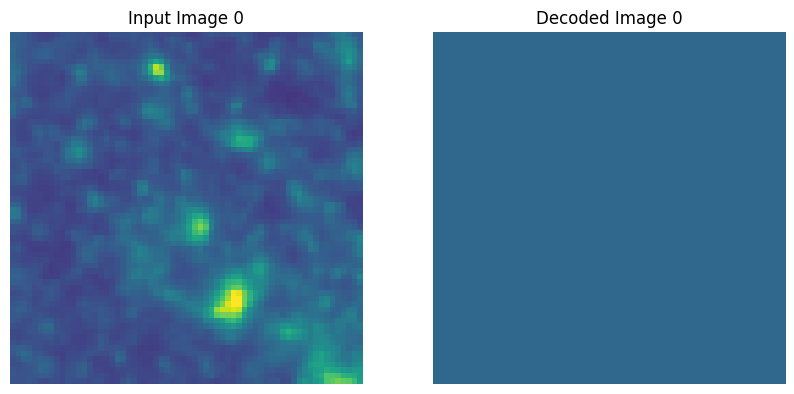

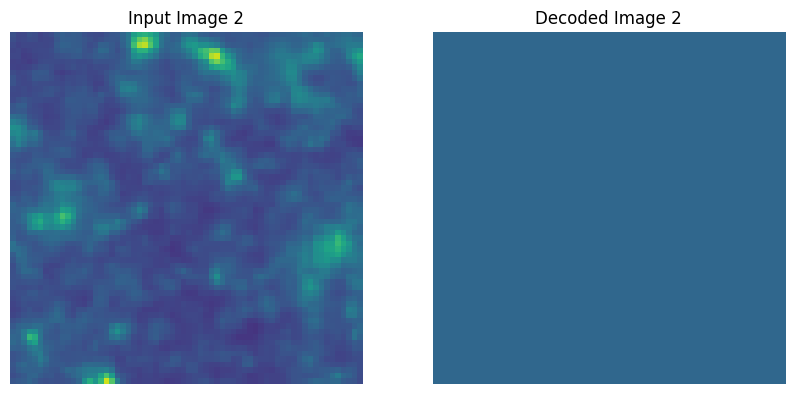

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming WL_tensor is a 4D tensor with shape (num_images, height, width, channels)
# and sub_image_size is the size of the second and third dimensions (height and width).
num_images = 5
sub_image_size = WL_tensor.shape[1]  # Assuming height and width are the same

# Get the outputs from the decoder
decoded_images = simple_decoder(simple_encoder(WL_tensor[:num_images,...])).numpy()

# Function to display images
def display_side_by_side(index):
    if index < 0 or index >= num_images:
        raise ValueError("Index out of bounds")

    # Select the specific input and output images
    input_image = WL_tensor[index, :, :, 0]  # Assuming grayscale, channel dimension is 0
    output_image = decoded_images[index, :, :, 0]  # Also assuming grayscale

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the input image in the first subplot
    axes[0].imshow(input_image, cmap='viridis', vmin=-0.05, vmax=.1)
    axes[0].set_title(f'Input Image {index}')
    axes[0].axis('off')  # Hide the axis

    # Display the output image in the second subplot
    axes[1].imshow(output_image, cmap='viridis', vmin=-0.05, vmax=.1)
    axes[1].set_title(f'Decoded Image {index}')
    axes[1].axis('off')  # Hide the axis


    # Display the images
    plt.show()

# Example usage for the first image
display_side_by_side(0)  # You can loop or call this function for other indices as well
display_side_by_side(2)